In [6]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import qda

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['font.size'] = 14

# Box-Cox transformation and return the transformed data
# [data_BC, lmbda] = stats.boxcox(data_stack, lmbda= )
# print('Lambda = %.3f' % lmbda)

def normality(data, alpha = 0.05):
    # Verify the normality of the data
    # Shapiro-Wilk test
    statsi, p_value_SW = stats.shapiro(data)
    print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)
    print('stats = ', statsi)

    if p_value_SW < alpha:
        print('The null hypothesis is rejected: Not Normal')
    else:
        print('The null hypothesis is accepted: data is Normal')
        
    # QQ-plot
    plt.figure(figsize=(5,5))
    stats.probplot(data, dist='norm', plot=plt)
    plt.show()
    print("--------------------------------------------------------------------------------")
    return p_value_SW

def run(data, alpha = 0.05):
    from statsmodels.sandbox.stats.runs import runstest_1samp

    statistics , pval_runs = runstest_1samp(data , correction=False)
    print('Runs test p-value = {:.3f}'.format(pval_runs))
    print('test statitics = {:.3f} '.format(statistics))
    if pval_runs < alpha:
        print('The null hypothesis is rejected: the process is NOT RANDOM')
    else:
        print('The null hypothesis is accepted: the process is RANDOM')
    print("--------------------------------------------------------------------------------")

def autocorr(data, alpha = 0.05, lag = 12): 
    #ACF and PACF
    # Plot the acf and pacf using the statsmodels library
    import statsmodels.graphics.tsaplots as sgt

    fig, ax = plt.subplots(2, 1)
    sgt.plot_acf(data , lags = int(len(data)/3), zero=False, ax=ax[0])
    fig.subplots_adjust(hspace=0.5)
    
    sgt.plot_pacf(data, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
    plt.show()

    print("\n### LBQ ###")
    #LBQ test for autocorrelation
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lag_test = lag
    lbq_test = acorr_ljungbox(data, lags=[lag_test], return_df=True)
    print('LBQ test statistic at lag %d = %f' % (lag_test, lbq_test.loc[lag_test,'lb_stat']))
    print('LBQ test p-value at lag %d = %f' % (lag_test, lbq_test.loc[lag_test,'lb_pvalue']))
    print("--------------------------------------------------------------------------------")

def Barlett(data, lag, alpha = 0.05):
    from statsmodels.tsa.stattools import acf, pacf
    from scipy import stats
    import numpy as np

    #autocorrelation function
    [acf_values, lbq, _] = acf(data, nlags = int(len(data)/3) , qstat=True, fft = False)
    #partial autocorrelation function
    pacf_value = pacf(data, nlags = int(len(data)/3))

    #Bartlett's test at lag n_lag
    lag_test = lag
    rk=abs(acf_values[lag_test])
    print('Test statistic rk= %f' % rk)

    #Critical values
    z_alpha2=stats.norm.ppf(1-alpha/2)
    print('Rejection region starts at %f' % (z_alpha2/np.sqrt(len(data))))
    
    # P-value calculation
    p_value = 2 * (1 - stats.norm.cdf(rk * np.sqrt(len(data))))
    print('P-value = %f' % p_value)

    if rk > z_alpha2/np.sqrt(len(data)):
        print('The null hypothesis is Rejected: There is significant autocorrelation at lag: ', lag)
    else: 
        print('The null hypothesis is Accepted: There is NO autocorrelation at lag: ', lag)
    print("--------------------------------------------------------------------------------")

def resid_check(model, index_start = 0):
    residuals = model.resid[index_start:]

    def resid_charts(model, index = index_start):
        residuals = model.resid[index_start:]
        #NORMALITY OF RESIDUALS
        fig, axs = plt.subplots(2, 2)
        fig.suptitle('Residual Plots')

        axs[0,0].set_title('Normal probability plot')
        stats.probplot(model.resid[index:], dist="norm", plot=axs[0,0])

        axs[0,1].set_title('Versus Fits')
        axs[0,1].scatter(model.fittedvalues[index:], residuals)

        fig.subplots_adjust(hspace=0.5)

        axs[1,0].set_title('Histogram')
        axs[1,0].hist(residuals)

        axs[1,1].set_title('Time series plot')
        axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
        plt.show(block=True)
        print("--------------------------------------------------------------------------------")

    normality(residuals, alpha = 0.05)
    resid_charts(model)

    #RANDOMNESS OF RESIDUALS
    run(residuals, alpha = 0.05)
    autocorr(residuals, alpha = 0.05)
    
    df_res = pd.DataFrame({'resid': model.resid})
    print("--------------------------------------------------------------------------------")
    return df_res

def FVC(data, model):
    plt.plot(data, 'o-', color='blue', label='Original data', alpha=0.7)
    plt.plot(model.fittedvalues, 's--', color='red', label='Fitted values', alpha=0.5 )
    plt.title('Time series plot')
    plt.xlabel('Index')
    plt.ylabel('Data')
    plt.grid()
    plt.legend()
    plt.show()
    print("--------------------------------------------------------------------------------")

def PCA(data, std = True , col_name = ['z1', 'z2', 'z3']):
    # Create the variance covariance matrix using pandas
    cov_matrix = data.cov()
    print('cov = \n', cov_matrix)

    # Compute the correlation matrix of the scores
    corr_matrix = data.corr()
    print('corr =\n', corr_matrix)
    print()

    if std: 
        data = (data - data.mean()) / data.std()
    else: 
        pass

    # import the libraries for PCA
    from sklearn.decomposition import PCA

    # Create the PCA object
    pca = PCA()
    # Fit the PCA object to the data
    pca.fit(data)
    # Print the eigenvalues
    print("Eigenvalues \n", pca.explained_variance_)
    # Print the eigenvectors 
    print("\nEigenvectors \n", pca.components_)
    # Print the explained variance ratio
    print("\nExplained variance ratio \n", pca.explained_variance_ratio_)
    # Print the cumulative explained variance ratio
    print("\nCumulative explained variance ratio \n", np.cumsum(pca.explained_variance_ratio_))

    # Compute the scores (i.e. all the principal components, n x 3) 
    scores = pca.transform(data)
    # create a dataframe with the scores
    scores_df = pd.DataFrame(scores, columns = col_name)

    # Plot the loadings
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    ax[0].plot(pca.components_[0], 'o-')
    ax[0].set_title('Loading 1')
    ax[1].plot(pca.components_[1], 'o-')
    ax[1].set_title('Loading 2')
    ax[2].plot(pca.components_[2], 'o-')
    ax[2].set_title('Loading 3')
    plt.show()

    # SCREE & CUM. EXP Var
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the eigenvalues (scree plot)
    ax[0].plot(pca.explained_variance_, 'o-')
    ax[0].set_xlabel('Component number')
    ax[0].set_ylabel('Eigenvalue')
    ax[0].set_title('Scree plot')
    # Plot the cumulative explained variance
    ax[1].plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
    # Add a bar chart to the plot
    ax[1].bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, width=0.5, alpha=0.5, align='center')
    ax[1].set_xlabel('Component number')
    ax[1].set_ylabel('Cumulative explained variance')
    ax[1].set_title('Cumulative explained variance')
    # Adjust the layout to make space for the titles
    plt.tight_layout()
    # Display the plots
    plt.show()

    return pca, scores_df;

def OC_curve(n , alpha = 0.0027, delta = 4):
    K = stats.norm.ppf(1-alpha/2)
    print('K = ', K)
    # Define a range of values for delta
    delta = np.linspace(0, delta, 100)
    # Compute the corresponding beta values
    beta = stats.norm.cdf(K - delta*np.sqrt(n)) - stats.norm.cdf(-K - delta*np.sqrt(n))
    # Plot the beta values
    plt.plot(delta, beta)
    plt.xlabel('Delta')
    plt.ylabel('Beta')
    plt.title('Operating characteristic curve')
    plt.show()

def beta(n , alpha, delta = 4):
    K = stats.norm.ppf(1-alpha/2)
    print('K = ', K)
    # Compute the corresponding beta values
    beta = stats.norm.cdf(K - delta*np.sqrt(n)) - stats.norm.cdf(-K - delta*np.sqrt(n)) 
    ARL1 = 1/(1-beta)
    print('beta is = ', beta, 'delta = ', delta, 'alpha = ', alpha, 'arl1 = ', ARL1)

def apply_boxcox(data, lmbda=None):
    """Apply Box-Cox transformation to the data. Use given lambda or compute it if not provided."""
    if lmbda is None:
        data_bc, lmbda = stats.boxcox(data)
    else:
        data_bc = stats.boxcox(data, lmbda=lmbda)
    print('lmbda = ', lmbda)
    return data_bc

def normality_check_for_qcc(data, alpha = 0.05, lmbda=None):
    data_stack = data.stack()
    print('normality test for stacked data:')
    Pval = normality(data_stack) 
    if Pval > alpha: 
        print("stacked data is normal, pvalue= %.3f" % Pval)
        pass
    else: 
        print("stacked data is NOT normal, pvalue= %.3f"% Pval)
        
        print("\nproceeding with boxcox>>>")
        data_BC = apply_boxcox(data_stack, lmbda=lmbda)
        print('Lambda = %.3f' % lmbda)

        Pval_2 = normality(data_BC)
        if Pval_2 > alpha: 
            print("Now data is normal, pvalue=%.3f"% Pval_2)
            # First we need to unstack the data
            data_BC_unstack = data_BC.reshape(data.shape)
            # and convert it to a DataFrame
            Normal_data = pd.DataFrame(data_BC_unstack, columns = data.columns)
            pass
        else: 
            print('boxcox failed')
            Normal_data = np.nan
            pass

    return Normal_data


### Code Sudo

##### modeling

In [ ]:
#OLS: 
x = 1                     #data['lag1'][1:] #shift 1 dasht
x = sm.add_constant(x) 
y = 1                    #data['Ex4'][1:]

model = sm.OLS(y, x).fit()

qda.summary(model)

#Check the resid must be NID
resid_check(model)

# Calculate the confidence interval for coefficient
CI_beta1 = model.conf_int(alpha=0.05).loc['name of regressor']
print('The confidence interval for beta1 is [%.3f, %.3f]' % (CI_beta1[0], CI_beta1[1]))

#predict: 
Yhat = model.predict([1,last_lag])

# compute the prediction interval
prediction_df = model.get_prediction([1,last_lag]).summary_frame(alpha=0.05)
print(prediction_df)


In [ ]:
# StepwiseRegression 
import qda
stepwise = qda.StepwiseRegression(add_constant = True, direction = 'both', alpha_to_enter = 0.15, alpha_to_remove = 0.15)

x = #data.iloc[1:, 1:3]
y = #data.iloc[1:, 0]

# Fit the model
model = stepwise.fit(y, x)

result = model.model_fit
qda.summary(result)

#Check on residuals
residuals = result.resid
fits = result.fittedvalues
print(result.params)

#predict the next value
data_predict = pd.DataFrame({'const': [1], 'Ex5_lag1': [data['Ex5'].iat[-1]], 'year': [1998], 'Ex5_lag4': [data['Ex5'].iat[-4]]})
prediction = result.predict(data_predict) 
print('The predicted value of Ex5 is %.3f.' % (prediction[0]))

# Compute the fit, confidence intervals and prediction intervals
prediction_summary = result.get_prediction(data_predict).summary_frame(alpha=0.05)
print(prediction_summary)

In [ ]:
# Arima
x = #data
model = qda.ARIMA(x, order=(0, 0, 0), add_constant = True) 
qda.ARIMAsummary(model)

In [ ]:
# PCA
# Create a correlation plot of the dataset
pd.plotting.scatter_matrix(data, alpha = 1)
plt.show()

# Create the variance covariance matrix using pandas
cov_matrix = data.cov()
print(cov_matrix)

# Compute the correlation matrix of the scores
corr_matrix = data.corr()
print(corr_matrix)


def compute_Z1_and_add_to_dataframe(dataframe, mu, sigma, column_name='Z1'):
    # Parameters given in the problem statement
    u1 = 0.65
    u2 = -0.19
    u3 = 0.72
    
    # Calculate Z1
    Z1 = u1 * ((dataframe['x1'] - mu[0]) / sigma[0]) + \
         u2 * ((dataframe['x2'] - mu[1]) / sigma[1]) + \
         u3 * ((dataframe['x3'] - mu[2]) / sigma[2])
    
    # Add Z1 to the dataframe with the specified column name
    dataframe[column_name] = Z1
    
    return dataframe

#def PCA_Reverse(data, pca, col_name, col_count):
    # First let's save in an array the mean and standard deviation of the original data
    mean = data.mean()
    std = data.std()
    _, scores_df = PCA(data)
    # Compute the reconstructed data_std using the first two principal components
    reconstructed_data_std = scores_df[col_name].dot(pca.components_[0:col_count, :])
    # Now use the mean and standard deviation to compute the reconstructed data
    reconstructed_data = reconstructed_data_std.dot(np.diag(std)) + np.asarray(mean)

    # Compare the original data with the reconstructed data
    print("Original data\n", data.head())
    print("\nReconstructed (ORIGINAL) data\n", reconstructed_data.head())

##### SPC iid/Non iid


In [ ]:
alpha = 
K_alpha = stats.norm.ppf(1-alpha/2)
print(K_alpha)

# Xbar _ R
data_XR_qcc = qda.ControlCharts.XbarR(data, K = K_alpha, subset_size=len(data))

# I-MR 
data_IMR = qda.ControlCharts.IMR(data,'GM', K = K_alpha, subset_size=len(data)) #len data initial ph1

# Xbar _ S
data_BC_XS = qda.ControlCharts.XbarS(data_BC_unstack)
data_XS = qda.ControlCharts.XbarS(data, mean = mean, sigma = stdev)

# Find the index of the I_TEST1 column different from NaN
OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]
print('The index of the OOC point is: {}'.format(OOC_idx)) # +1 !!!!!
# make a copy of the data
data_2 = data.copy()
# replace the OOC point with NaN
data_2['GM'].iloc[OOC_idx] = np.nan

#concat new data
# Define the array with the new observations
new_obs = np.array((1.327, 1.594, 0.716, 1.767, 0.915, 2.524, 0.563, 2.053))
# Add the new observations to the dataset
new_data = pd.concat([data, pd.DataFrame(new_obs, columns=['GM'])], ignore_index=True)


# ARL vs Delat 
n = 4 
alpha = 0.004
K = stats.norm.ppf(1-alpha/2)
print(K)

# Define a range of values for delta
delta = np.linspace(0, 2, 100)
# Compute the corresponding beta values
beta = stats.norm.cdf(K - delta*np.sqrt(n)) - stats.norm.cdf(-K - delta*np.sqrt(n))

ARL0 = 1 / alpha
# Compute ARL using the previous values of beta
ARL1 = 1/(1-beta)

# Plot the ARL values
plt.plot(delta, ARL1)
plt.xlabel('Delta')
plt.ylabel('ARL')
plt.title('Average run length')
plt.show()

#NEW MR after boxcox:
data_IMR['MR_boxcox'],_ = apply_boxcox(data_IMR['MR'][1:], 0.4)

df_MR_boxcox = df_SCC[['MR_boxcox']].iloc[1:]
df_MR_boxcox = qda.ControlCharts.IMR(df_MR_boxcox, 'MR_boxcox', plotit=False)

# Plot the I chart
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I chart of MR_boxcox'))

ax.plot(df_MR_boxcox['MR_boxcox'], color='mediumblue', linestyle='--', marker='o')

ax.plot(df_MR_boxcox['I_UCL'], color='firebrick', linewidth=1)
ax.plot(df_MR_boxcox['I_CL'], color='g', linewidth=1)
ax.plot(df_MR_boxcox['I_LCL'], color='firebrick', linewidth=1)


ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(df_MR_boxcox)+.5, df_MR_boxcox['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df_MR_boxcox['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(df_MR_boxcox)+.5, df_MR_boxcox['I_CL'].iloc[0], 'CL = {:.2f}'.format(df_MR_boxcox['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(df_MR_boxcox)+.5, df_MR_boxcox['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df_MR_boxcox['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(df_MR_boxcox['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()

##### Small Shift

In [ ]:
# CUSUM 
df_CUSUM = qda.ControlCharts.CUSUM(data, 'EXE4', params=(h,k), mean = 10.75, sigma_xbar = sigma_xbar) #subset_size = phase1_size

# input the parameters of the CUSUM control chart
h = 4
k = 0.5
# extract the sample_mean column from data_XS and put it in a new dataframe
data_mean = pd.DataFrame(data_XS['sample_mean'])
# Design the CUSUM control chart
data_CUSUM = qda.ControlCharts.CUSUM(data_mean, 'sample_mean', params=(h,k), mean = mean, sigma_xbar = stdev/np.sqrt(n))  #subset_size = phase1_size


#EWMA
lambda_ = 0.2
df_EWMA = qda.ControlCharts.EWMA(data, 'EXE4', lambda_, mean = 10.75, sigma_xbar = sigma_xbar)  #subset_size = phase1_size

##### Multivariate

In [ ]:
#p = 2           # number of random variables
#m = 10          # number of samples
#n = 3           # number of replicates (sample size)
#alpha = 0.05    # significance level

### EXAM Solution

In [ ]:
Path = ""
data = pd.read_csv(Path)
print(data)
d = data['']

plt.plot(data[''], 'o-')
plt.grid()
plt.show()

# Make a scatter plot of all the columns against the index
plt.plot(data['X1'], linestyle='none', marker='o', label = 'x1')
plt.plot(data['X2'], linestyle='none', marker='o', label = 'x2')
plt.plot(data['X3'], linestyle='none', marker='o', label = 'x3')
plt.plot(data['X4'], linestyle='none', marker='o', label = 'x4')
plt.plot(data['X5'], linestyle='none', marker='o', label = 'x5')
# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

data_all = pd.concat([data, data_p2], ignore_index=True)

# EX1

In [3]:
Path = "/Users/amirh_jandaghian/Downloads/QDA Exam/cold_rolling.csv"
data = pd.read_csv(Path)
print(data)

        x1      x2
0   0.0080  0.0080
1   0.0120  0.0120
2   0.0653 -0.0601
3   0.0777 -0.0506
4   0.2732  0.1099
..     ...     ...
95 -0.1220 -0.9696
96 -0.0972 -0.9869
97 -0.0010 -1.0260
98  0.1422 -0.9501
99  0.2626 -0.8239

[100 rows x 2 columns]


p-value of the Shapiro-Wilk test: 0.003
stats =  0.9572640061378479
The null hypothesis is rejected: Not Normal


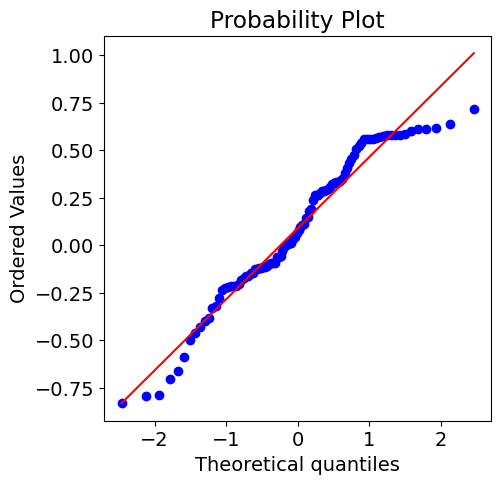

--------------------------------------------------------------------------------
Runs test p-value = 0.000
test statitics = -9.045 
The null hypothesis is rejected: the process is NOT RANDOM
--------------------------------------------------------------------------------


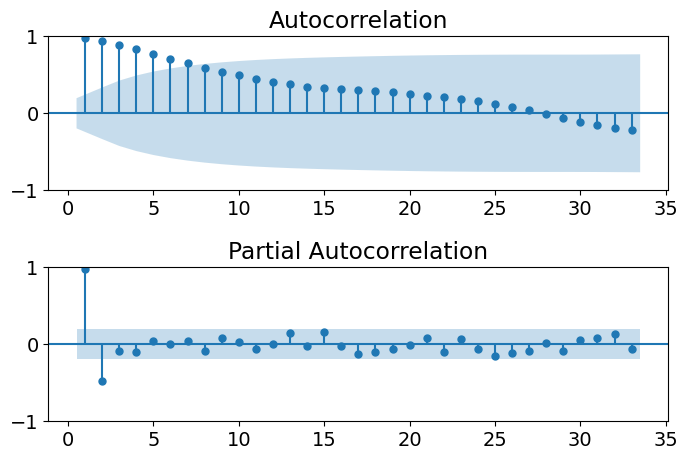


### LBQ ###
LBQ test statistic at lag 12 = 654.141835
LBQ test p-value at lag 12 = 0.000000
--------------------------------------------------------------------------------


In [7]:
d = data['x1']
Normal_Pval = normality(data= d)
run(data= d)
autocorr(data= d)

p-value of the Shapiro-Wilk test: 0.007
stats =  0.9633422493934631
The null hypothesis is rejected: Not Normal


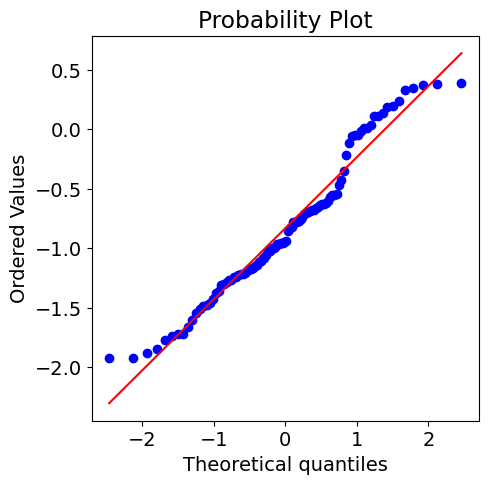

--------------------------------------------------------------------------------
Runs test p-value = 0.000
test statitics = -9.648 
The null hypothesis is rejected: the process is NOT RANDOM
--------------------------------------------------------------------------------


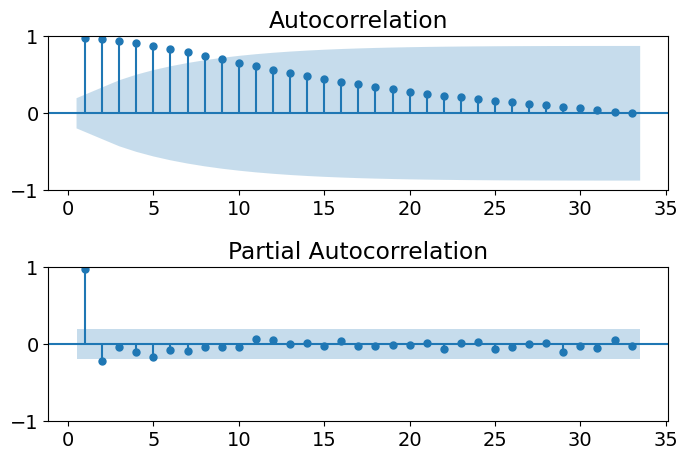


### LBQ ###
LBQ test statistic at lag 12 = 848.118453
LBQ test p-value at lag 12 = 0.000000
--------------------------------------------------------------------------------


In [8]:
d2 = data['x2']
Normal_Pval = normality(data= d2)
run(data= d2)
autocorr(data= d2)

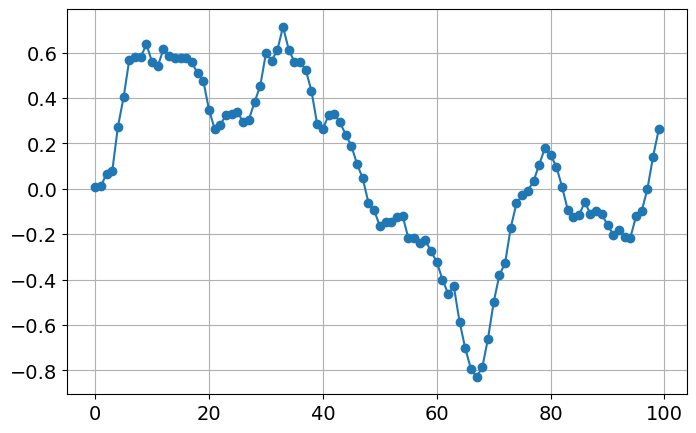

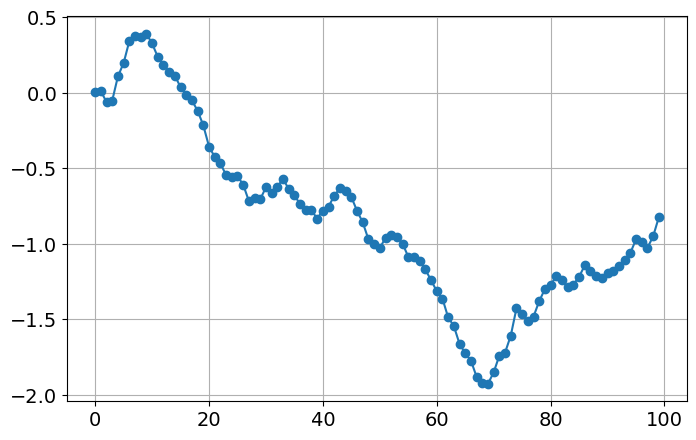

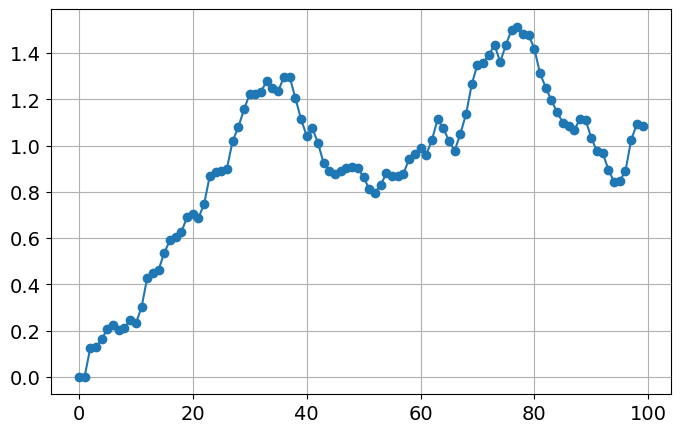

In [15]:
plt.plot(d, 'o-')
plt.grid()
plt.show()

plt.plot(d2, 'o-')
plt.grid()
plt.show()

plt.plot(data['diff'], 'o-')
plt.grid()
plt.show()

In [ ]:
(All students) Using appropriate statistical tests on the original variables 'x1' and 'x2', verify if the
average difference between the two sensors in the last 9 minutes of production is equal to 1 mm at 99%
confidence level. Compute the corresponding confidence interval.


In [12]:
data['diff'] = abs(d - d2)
data.tail(10)
test = data['diff'].tail(9)
test

91    0.9748
92    0.9678
93    0.8961
94    0.8436
95    0.8476
96    0.8897
97    1.0250
98    1.0923
99    1.0865
Name: diff, dtype: float64

In [19]:
t0, p_value_t0 = stats.ttest_ind(d.tail(9), d2.tail(9), equal_var= True)
print('%.4f'%p_value_t0)
print(t0)

0.0000
14.109122049056172


In [27]:
data['x1_diff'] = data['x1'].diff(1)
data['x2_diff'] = data['x2'].diff(1)

data

,x1,x2,diff,x1_diff,x2_diff
0,0.0080,0.0080,0.0000,NaN,NaN
1,0.0120,0.0120,0.0000,0.0040,0.0040
2,0.0653,-0.0601,0.1254,0.0533,-0.0721
3,0.0777,-0.0506,0.1283,0.0124,0.0095
4,0.2732,0.1099,0.1633,0.1955,0.1605
...,...,...,...,...,...
95,-0.1220,-0.9696,0.8476,0.0939,0.0899
96,-0.0972,-0.9869,0.8897,0.0248,-0.0173
97,-0.0010,-1.0260,1.0250,0.0962,-0.0391
98,0.1422,-0.9501,1.0923,0.1432,0.0759


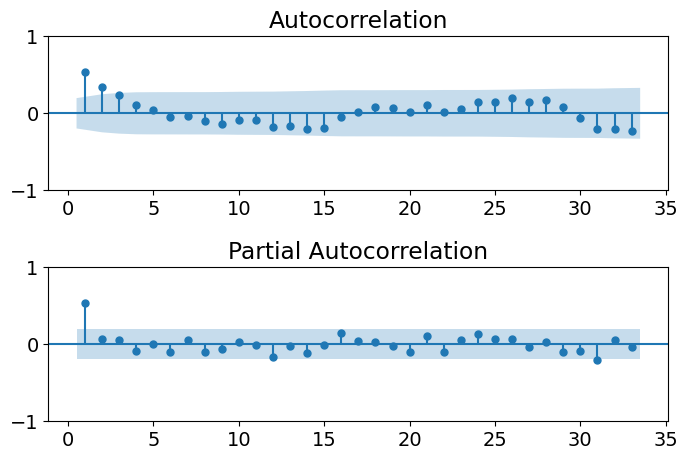


### LBQ ###
LBQ test statistic at lag 12 = 57.275487
LBQ test p-value at lag 12 = 0.000000
--------------------------------------------------------------------------------


In [29]:
autocorr(data['x1_diff'][1:])

In [47]:
# Arima x1
x = data['x1']
model1 = qda.ARIMA(x, order=(1, 1, 0), add_constant = False) 
qda.ARIMAsummary(model1)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=1, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term   Coef  SE Coef  T-Value    P-Value
ar.L1 0.5462   0.0876   6.2352 4.5109e-10

RESIDUAL SUM OF SQUARES
-------------------------
  DF     SS     MS
98.0 0.3776 0.0039

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      6.8712   0.8660
  24     19.3684   0.7321
  36     34.0288   0.5626
  48     39.9525   0.7891


p-value of the Shapiro-Wilk test: 0.901
stats =  0.993165910243988
The null hypothesis is accepted: data is Normal


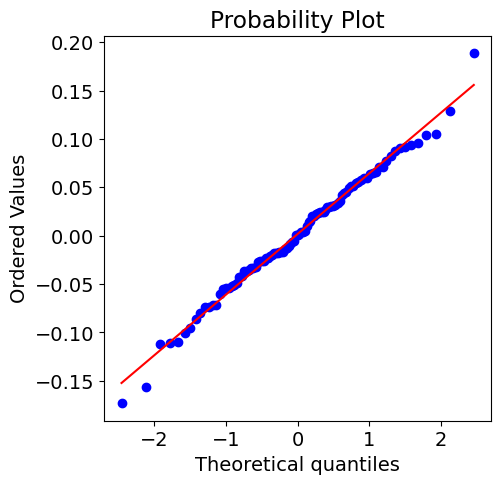

--------------------------------------------------------------------------------


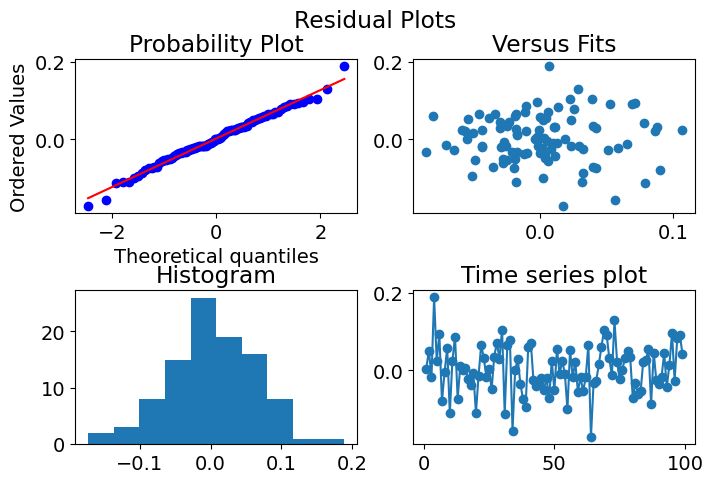

--------------------------------------------------------------------------------
Runs test p-value = 0.912
test statitics = 0.110 
The null hypothesis is accepted: the process is RANDOM
--------------------------------------------------------------------------------


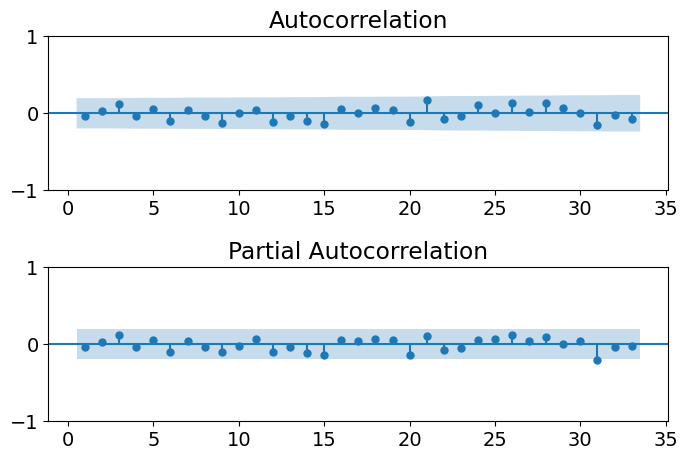


### LBQ ###
LBQ test statistic at lag 12 = 6.871168
LBQ test p-value at lag 12 = 0.866009
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [42]:
df_SCCx1 = resid_check(model= model1, index_start=1)

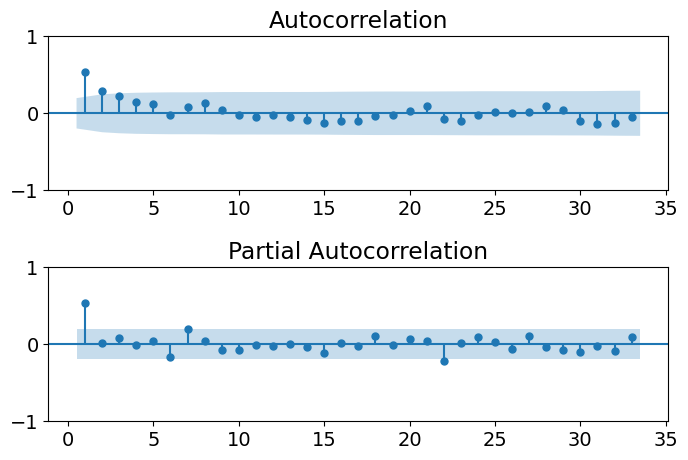


### LBQ ###
LBQ test statistic at lag 12 = 50.034634
LBQ test p-value at lag 12 = 0.000001
--------------------------------------------------------------------------------


In [43]:
autocorr(data['x2_diff'][1:])

In [49]:
# Arima x1
x = data['x2']
model2 = qda.ARIMA(x, order=(1, 1, 0), add_constant = False) 
qda.ARIMAsummary(model2)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=1, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term   Coef  SE Coef  T-Value    P-Value
ar.L1 0.5544   0.0766   7.2338 4.6958e-13

RESIDUAL SUM OF SQUARES
-------------------------
  DF     SS     MS
98.0 0.3086 0.0031

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12     10.9243   0.5354
  24     21.5765   0.6045
  36     27.3953   0.8480
  48     33.5026   0.9443


p-value of the Shapiro-Wilk test: 0.566
stats =  0.988664448261261
The null hypothesis is accepted: data is Normal


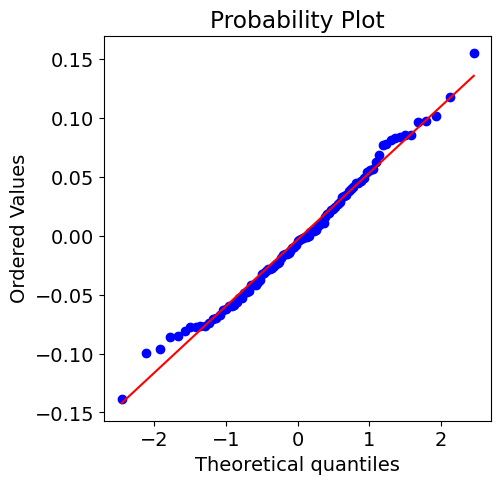

--------------------------------------------------------------------------------


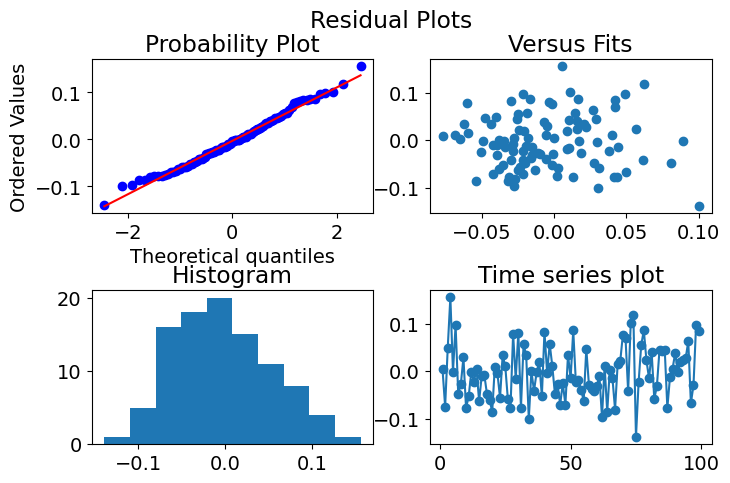

--------------------------------------------------------------------------------
Runs test p-value = 0.763
test statitics = -0.302 
The null hypothesis is accepted: the process is RANDOM
--------------------------------------------------------------------------------


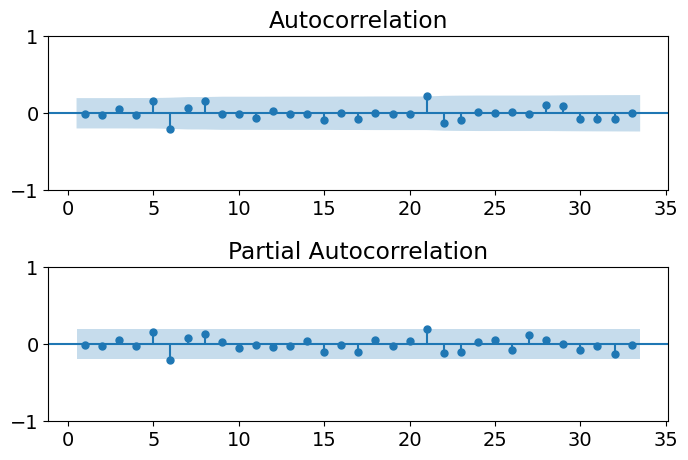


### LBQ ###
LBQ test statistic at lag 12 = 10.924312
LBQ test p-value at lag 12 = 0.535416
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [50]:
df_SCCx2 = resid_check(model= model2, index_start=1)

In [55]:
alpha = 0.003 / 2 
alpha
K_alpha = stats.norm.ppf(1-alpha/2)
print(K_alpha)

3.174683527455065


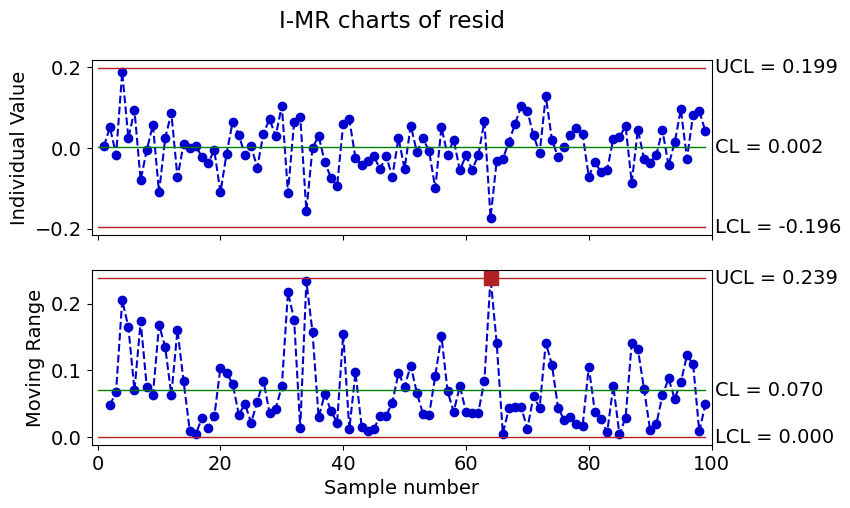

,resid,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
64,-0.1732,0.239,0.1993,0.0018,-0.1956,NaN,0.2385,0.0702,0,0.239


In [58]:
df_SCCx1_qcc = qda.ControlCharts.IMR(df_SCCx1, 'resid', K = K_alpha)
df_SCCx1_qcc[df_SCCx1_qcc['MR_TEST1'].notna()]

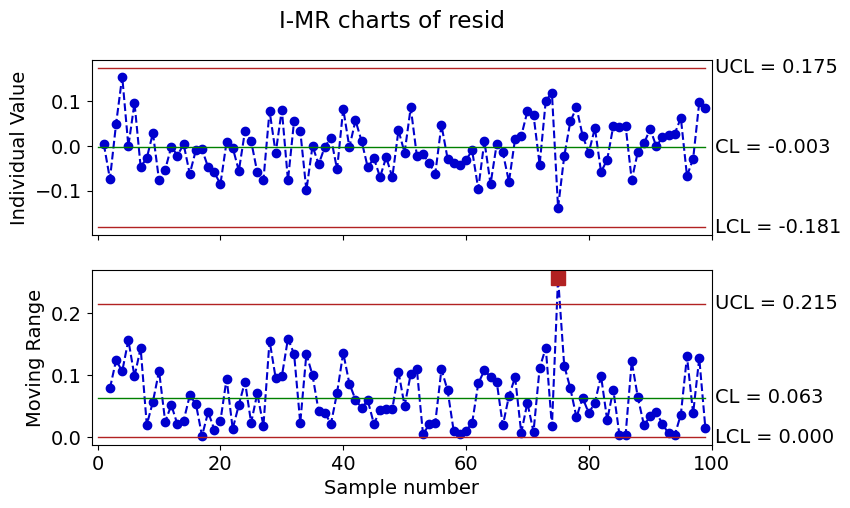

,resid,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
75,-0.1388,0.257,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,0.257


In [60]:
df_SCCx2_qcc = qda.ControlCharts.IMR(df_SCCx2, 'resid', K = K_alpha)
df_SCCx2_qcc[df_SCCx2_qcc['MR_TEST1'].notna()]


In [61]:
df_SCCx2_qcc

,resid,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
0,NaN,NaN,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
1,0.0040,NaN,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
2,-0.0743,0.0783,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
3,0.0495,0.1238,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
4,0.1552,0.1058,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
...,...,...,...,...,...,...,...,...,...,...
95,0.0627,0.0360,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
96,-0.0671,0.1299,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
97,-0.0295,0.0376,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
98,0.0976,0.1271,0.1751,-0.003,-0.1812,NaN,0.2152,0.0633,0,NaN
